# Introduction

Hello Hiring Team,
In an attempt to make a good first impression I decided to simulate what I think is one of the task we will have to deal with in the Data Scientist position at Wise... **Customer Segmentation!**

## Dataset Used for this Simulation
For this project I will use the "Bank Customer Segmentation" from Kaggle **[Link](https://www.kaggle.com/datasets/shivamb/bank-customer-segmentation/data)**. While this dataset may not perfectly mirror Wise’s financial ecosystem, as it deals with transactions instead of transfers, I still belive it can provide a valuable foundation for simulating real-world segmentation challenges!

Now, let’s dive in and load the dataset!

In [1]:
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


/Users/claudiogiannini/Desktop/Projects/sideproject_example/myenv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download latest version using kagglehub and add the file path to load the file
path = kagglehub.dataset_download("shivamb/bank-customer-segmentation")
file_path = os.path.join(path, "bank_transactions.csv")

# Quick check at the file location
print("Path to dataset files:", file_path)

# Load the dataframe
df = pd.read_csv(file_path)

Path to dataset files: /Users/claudiogiannini/.cache/kagglehub/datasets/shivamb/bank-customer-segmentation/versions/1/bank_transactions.csv


# Exploring Our Dataframe

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB
None


For an easier data manipulation and engeneering later one let's change the type for the columns CustomerDOB and TransactionDate and turn it into datetime. This will simplify the creation of future possible columns like age for our analysis!

In [4]:
# Convert both columns to datetime format
df["TransactionDate"] = pd.to_datetime(df["TransactionDate"])
df["CustomerDOB"] = pd.to_datetime(df["CustomerDOB"])
print(df.info())

/var/folders/z1/_f1dgn9d3vg65st2m_lw8_3c0000gn/T/ipykernel_24614/1723614549.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["TransactionDate"] = pd.to_datetime(df["TransactionDate"])
/var/folders/z1/_f1dgn9d3vg65st2m_lw8_3c0000gn/T/ipykernel_24614/1723614549.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["CustomerDOB"] = pd.to_datetime(df["CustomerDOB"])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   TransactionID            1048567 non-null  object        
 1   CustomerID               1048567 non-null  object        
 2   CustomerDOB              1045170 non-null  datetime64[ns]
 3   CustGender               1047467 non-null  object        
 4   CustLocation             1048416 non-null  object        
 5   CustAccountBalance       1046198 non-null  float64       
 6   TransactionDate          1048567 non-null  datetime64[ns]
 7   TransactionTime          1048567 non-null  int64         
 8   TransactionAmount (INR)  1048567 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 72.0+ MB
None


### NA Values Handling
Great! Now that this is done let's check for NA values!

In [5]:
missing_values = df.isna().sum()
print(missing_values)

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64


So we have the CustomerDOB has 3397 NA values, CustGender has 1100, CustLocation has 151 and CustAccountBalance 2369. Since we talking about 1048567 these row can directly be dropped instead of imputed. But before doing so let's check if any CustAccountBalance = 0 exists. This is because the bank for some reason might record them as NA. If that's the case (No CustAccountBalance = 0 exists) we might decide to replace the NA with 0. 

In [6]:
zero_balance_count = (df["CustAccountBalance"] == 0).sum()
print(f"Number of customers with 0 account balance: {zero_balance_count}")

Number of customers with 0 account balance: 2711


So that was not the case and the NA is due to a mistake, so we will drop all the NA in the df

In [7]:
# Drop rows where any of the specified columns have NA values
df_cleaned = df.dropna(subset=["CustomerDOB", "CustGender", "CustLocation", "CustAccountBalance"])

print(f"Number of rows: {len(df)}")
print(f"Number of rows: {len(df_cleaned)}")

na_rate = (len(df) - len(df_cleaned)) / len(df)
print(f"NA Rate: {na_rate:.2%}")

Number of rows: 1048567
Number of rows: 1041614
NA Rate: 0.66%


Since the number of missing values was very small, I saw no strong reason to apply imputation. Additionally, the nature of the data didn’t lend itself well to reliable imputations—for example, account balances and dates of birth are not values that can be easily inferred using mean or median replacements. Instead, I opted to drop the missing values to maintain data integrity.

### Last Check to Our Dataset
Now let's look at our df_cleaned to check for any othe anomaly

In [8]:
df_cleaned.describe()

,CustomerDOB,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
count,1041614,1.041614e+06,1041614,1.041614e+06,1.041614e+06
mean,1985-07-03 08:17:32.308436800,1.149986e+05,2016-07-25 19:23:05.559718400,1.571221e+05,1.566096e+03
min,1800-01-01 00:00:00,0.000000e+00,2016-01-08 00:00:00,0.000000e+00,0.000000e+00
25%,1983-12-08 00:00:00,4.728140e+03,2016-06-09 00:00:00,1.240410e+05,1.600000e+02
50%,1988-12-13 00:00:00,1.676852e+04,2016-08-20 00:00:00,1.642470e+05,4.575000e+02
75%,1992-08-22 00:00:00,5.742885e+04,2016-09-09 00:00:00,2.000220e+05,1.200000e+03
max,2074-12-31 00:00:00,1.150355e+08,2016-12-09 00:00:00,2.359590e+05,1.560035e+06
std,NaN,8.467609e+05,NaN,5.126352e+04,6.561464e+03


Not so good... for CustomerDOB we have people born into the future and people born in the early 800s. A better approach would definetly be to investigate into why this is happening but since we have no way to retrieve this information I am afraid that the only thing we can do is to cut the unrealistic (or impossible in case of people born into the future ahah) values. To do so we will consider as the date in which the analysis occured the maximum transaction date, which is also the latest date available in our record (This will also be used later one)

In [9]:
today = df_cleaned["TransactionDate"].max() # Important variable which simulte the day in which the analysis is conducted

min_birthdate = today - pd.DateOffset(years=100)
max_birthdate = today - pd.DateOffset(years=16)

# Filter out unrealistic birthdates
df_cleaned = df_cleaned[(df_cleaned["CustomerDOB"] >= min_birthdate) & 
                         (df_cleaned["CustomerDOB"] <= max_birthdate)]

df_cleaned.describe()

,CustomerDOB,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
count,879861,8.798610e+05,879861,879861.000000,8.798610e+05
mean,1987-10-09 09:12:29.945275520,7.705016e+04,2016-07-25 08:24:29.915815936,157621.122482,1.270415e+03
min,1975-01-01 00:00:00,0.000000e+00,2016-01-08 00:00:00,0.000000,0.000000e+00
25%,1984-05-03 00:00:00,4.207390e+03,2016-06-09 00:00:00,124304.000000,1.460000e+02
50%,1988-07-26 00:00:00,1.448272e+04,2016-08-20 00:00:00,164957.000000,3.950000e+02
75%,1991-09-13 00:00:00,4.631625e+04,2016-09-09 00:00:00,200500.000000,1.000000e+03
max,2000-12-09 00:00:00,4.316556e+07,2016-12-09 00:00:00,235959.000000,1.560035e+06
std,NaN,3.526216e+05,NaN,51743.395037,5.405121e+03


Great! Noe the dates go from 1975 to 2000 which is a bit more realistic!

## Data Visualization
### Distribution of Customer Account Balances
Let's first check the Account Balances of the customer. What we expect to see in this type of datat is a right-skewed distribution, meaning that most customers have low account balances while few have very high account balances.

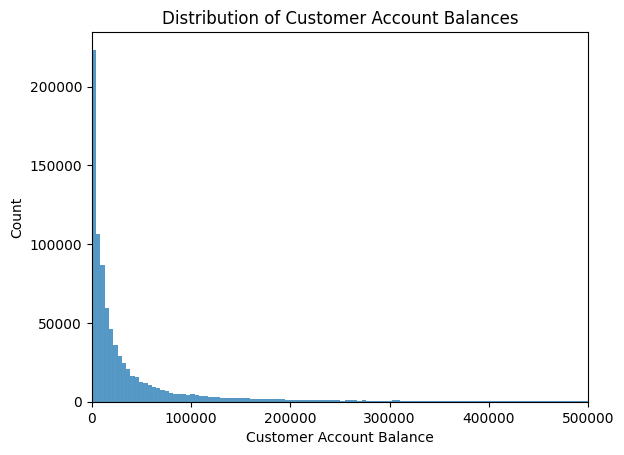

In [10]:
plt.figure()
sns.histplot(df_cleaned["CustAccountBalance"], bins=10000)
plt.xlim(0, 500000) 
plt.xlabel("Customer Account Balance")
plt.ylabel("Count")
plt.title("Distribution of Customer Account Balances")
plt.show()

This is also the case for our data! This might also influence the analysis later on as subsdividing into classes might also give unbalanced distribution of clusters! There are many other Visualization that could be done for a more in depth analysis but for our example we will limit it to this!

# Data Engeneering
Now let's focus on modifying our dataset in preparation for our Analysis. Our goal is to transform the dataset into a customer-level view by aggregating transaction data.

We will group by Customer ID and compute the following features:
- Age
- Count of Transaction IDs
- Transactions Amount Mean
- Transactions Amount Sum
- Account Balance Max
- Account Balance Min
- Account Balance Mean
- Most Recent Transaction
- Recency




In [11]:
# Compute Age of customer
df_cleaned["Age"] = (today - df_cleaned["CustomerDOB"]).dt.days // 365

customer_group = df_cleaned.groupby("CustomerID").agg(
    Age=("Age", "max"),  
    TransactionCount=("TransactionID", "count"),
    TransactionAmountMean=("TransactionAmount (INR)", "mean"),
    TransactionAmountSum=("TransactionAmount (INR)", "sum"),
    AccountBalanceMax=("CustAccountBalance", "max"),
    AccountBalanceMin=("CustAccountBalance", "min"),
    AccountBalanceMean=("CustAccountBalance", "mean"),
    LastTransactionDate=("TransactionDate", "max")
).reset_index()

# Compute 'Recency' (days since last transaction)
customer_group["Recency"] = (today - customer_group["LastTransactionDate"]).dt.days


In [12]:
print(customer_group.describe())

                 Age  TransactionCount  TransactionAmountMean  \
count  761481.000000     761481.000000           7.614810e+05   
mean       29.111816          1.155460           1.271465e+03   
min        16.000000          1.000000           0.000000e+00   
25%        25.000000          1.000000           1.600000e+02   
50%        28.000000          1.000000           4.200000e+02   
75%        33.000000          1.000000           1.041360e+03   
max        41.000000          6.000000           1.560035e+06   
std         5.200817          0.409346           5.361700e+03   

       TransactionAmountSum  AccountBalanceMax  AccountBalanceMin  \
count          7.614810e+05       7.614810e+05       7.614810e+05   
mean           1.467914e+03       8.652068e+04       6.804308e+04   
min            0.000000e+00       0.000000e+00       0.000000e+00   
25%            1.750000e+02       5.069190e+03       3.417070e+03   
50%            4.870000e+02       1.698716e+04       1.245807e+04   


Lastly we use StandardScaler to ensure that all features have the same scale and contribute equally to clusering

In [13]:
features = ["Age", "TransactionCount", "TransactionAmountSum", "TransactionAmountMean", 
            "AccountBalanceMean", "AccountBalanceMax", "AccountBalanceMin", "Recency"]

# Standardize the data using StandardScaler()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_group[features])

# Analysis
Fantstic so we are now ready for our analysis. We use the Elbow Method to determine the optimal number of clusters (K) for K-Means clustering. By iterating over different values of K (from 2 to 30) and computing the inertia. Then we identifyt the elbow point where adding more clusters results in diminishing improvements

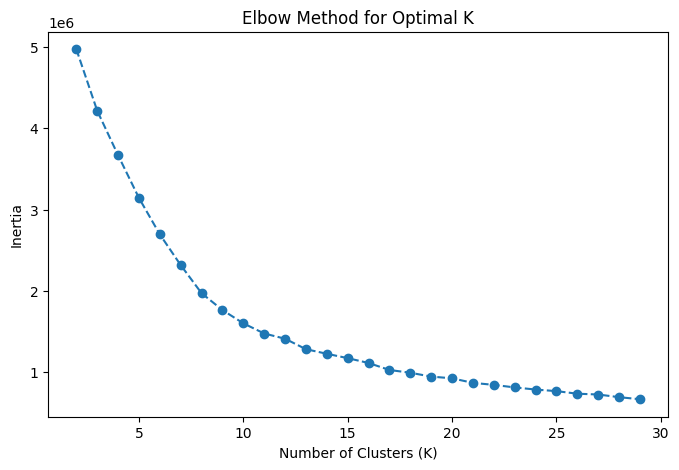

In [14]:
# Try different K values and check inertia from K=2 to K=30
inertia = []
K_range = range(2, 30)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker="o", linestyle="--")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()

Great! So we identify this point to be a K=8. Now we fit the model on the standardized data (X_scaled) and assign each customer to a cluster using kmeans.fit_predict(). This results in a new column, “Cluster”, in our dataset, indicating each customer’s assigned group. Finally, we check the distribution of customers across clusters using value_counts(), which helps us understand how many customers belong to each segment.

In [15]:
kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)
customer_group["Cluster"] = kmeans.fit_predict(X_scaled)

# Check how many customers per cluster
print(customer_group["Cluster"].value_counts())

Cluster
0    325913
7    176977
1    139664
4    103214
5     10604
6      4335
3       760
2        14
Name: count, dtype: int64


This is a highly unbalanced but I believe that it's normal due to the high skeweness of this type of financial data like we show in the Data Visualization section

## Results
In this section, we analyze the characteristics of each cluster by computing the mean values of key numerical features. This helps us interpret the distinct profiles of customer segments based on attributes such as transaction behavior, account balance, and recency. Additionally, we apply Principal Component Analysis (PCA) to reduce the high-dimensional feature space to two components for visualization. The scatter plot provides an overview of how clusters are distributed in lower-dimensional space, offering insights into their separability and structure. While some clusters appear well-defined, others may have overlapping characteristics, suggesting potential areas for further refinement.

In [16]:
numeric_cols = customer_group.select_dtypes(include=['number']).columns
customer_group.groupby("Cluster")[numeric_cols].mean()

,Age,TransactionCount,TransactionAmountMean,TransactionAmountSum,AccountBalanceMax,AccountBalanceMin,AccountBalanceMean,Recency,Cluster
Cluster,,,,,,,,,
0,25.488311,1.000000,757.749250,757.749250,3.441833e+04,3.441833e+04,3.441833e+04,97.102024,0.0
1,28.218933,1.005098,1017.504464,1022.030650,4.412579e+04,4.385477e+04,4.399028e+04,272.319911,1.0
2,33.642857,1.000000,699217.491429,699217.491429,1.668494e+05,1.668494e+05,1.668494e+05,115.714286,2.0
3,33.482895,1.056579,5051.148779,5252.363316,7.873430e+06,7.093484e+06,7.467467e+06,137.072368,3.0
4,31.744860,2.120778,1071.806619,2275.115685,1.092036e+05,1.313702e+04,5.916471e+04,89.463251,4.0
5,33.107224,1.107978,2300.380642,2518.137266,1.595435e+06,1.281278e+06,1.431995e+06,127.682667,5.0
6,30.983852,1.184544,41298.217605,46442.429315,2.008116e+05,1.562928e+05,1.771558e+05,129.922491,6.0
7,34.649350,1.000000,1420.821532,1420.821532,7.604205e+04,7.604205e+04,7.604205e+04,103.329071,7.0


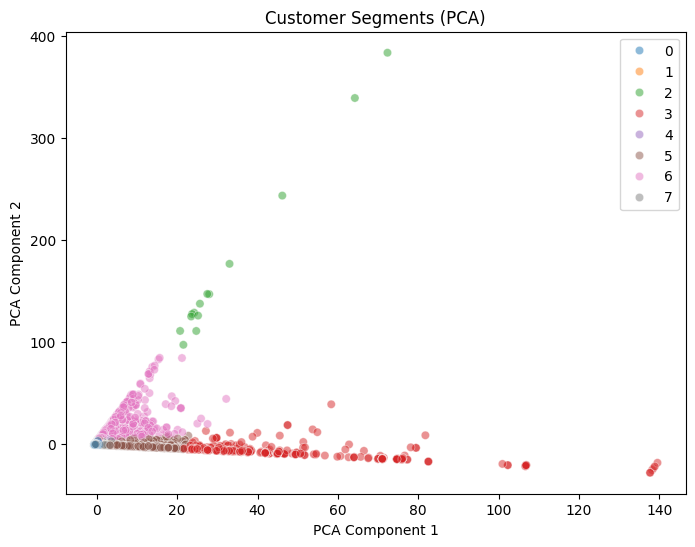

In [17]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=customer_group["Cluster"], palette="tab10", alpha=0.5)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Customer Segments (PCA)")
plt.legend()
plt.show()

## Cluster Identification
### Cluster 3 & 5 - High Net Worth Individuals (HNWIs)
- Both have high account balances.  
- Key difference:  
  - Cluster 3 has very high transaction amounts, possibly business owners, investors, or high spenders.  
  - Cluster 5 has lower transaction amounts but still high balances, which could indicate they use the bank primarily for savings or investments.  
- Cluster 3 actively moves money, while Cluster 5 might store funds and use them occasionally.  

### Cluster 6 - High Balance & High Transactions
- Higher than average account balance and transaction amount.  
- This group could represent affluent individuals who actively use this bank for large transactions or business owners making frequent payments.  

### Cluster 2 - Small Group, Super High Transactions
- Only 14 members but extremely high transaction amounts.  
- This could indicate corporate accounts or very wealthy individuals making large transactions.  
- Possibly a group of businesses or VIP customers with significant cash flow.  

### Cluster 0 - Young, Frequent Users, Low Balance & Transaction Amount
- Younger customers (average age 25) with low balances and low transaction amounts.  
- Frequent users with low recency.  
- Likely daily banking users, such as students or young professionals without significant savings.  

### Cluster 7 - Older Version of Cluster 1
- Similar to Cluster 1 but older.  
- More financially stable due to age.  
- Likely includes retired professionals or low-activity older customers.  

### Cluster 1 - Sporadic, Older Users
- Older than Cluster 0.  
- Higher balance and transaction amounts but less frequent usage.  
- Possibly occasional users who primarily save rather than transact frequently.  

### Cluster 4 - Frequent Users, Moderate-High Income
- Low recency, indicating active users.  
- Higher balances than Clusters 0 and 1.  
- More frequent use of transactions.  
- Likely includes middle-class professionals using the bank for daily transactions and salary deposits.  
